# Comparing ABM with empirical model

## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Preamble

In [2]:
# This is the dataset from a different model which uses German statistics for EV use. Source: https://zenodo.org/record/4514928
dataset = pd.read_csv("emobpy_timeseries_original.csv")

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048573 entries, 0 to 1048572
Data columns (total 5 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   date                      1048573 non-null  object 
 1   ID                        1048573 non-null  int64  
 2   VehicleMobility Location  1048573 non-null  object 
 3   Distance_km               1048573 non-null  float64
 4   Consumption_kWh           1048573 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 40.0+ MB


In [4]:
dataset.tail()

,date,ID,VehicleMobility Location,Distance_km,Consumption_kWh
1048568,03/12/2020 14:00,29,home,0.0,0.0
1048569,03/12/2020 14:15,29,home,0.0,0.0
1048570,03/12/2020 14:30,29,home,0.0,0.0
1048571,03/12/2020 14:45,29,home,0.0,0.0
1048572,03/12/2020 15:00,29,home,0.0,0.0


## Data Fixes

In [5]:
# The dataset captures not only driving a vehicle but also downtime, we're only interested in driving.
driving_dataset = dataset.loc[(dataset['VehicleMobility Location'] == "driving")]

In [6]:
# We take data for only one vehicle.
fifteen_vehicle_data = driving_dataset.loc[(driving_dataset['ID'] < 15)]
fifteen_vehicle_data = fifteen_vehicle_data.loc[(fifteen_vehicle_data['Distance_km'] <= 28)]

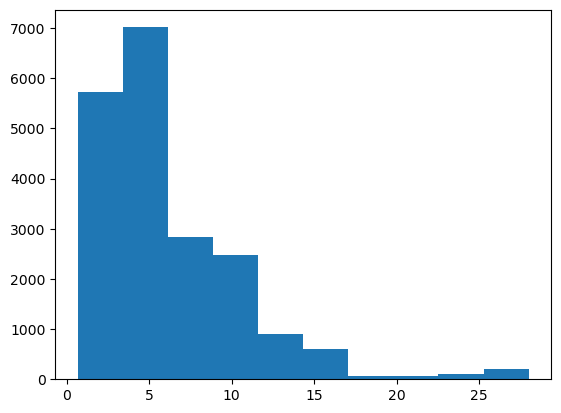

In [7]:
plt.hist(data = fifteen_vehicle_data, x="Distance_km")
plt.show()

In [8]:
# convert the 'Date' column to datetime format
# Convert to datetime is a relatively slow process, so if we only do this for the data that we care about then it should be quicker
fifteen_vehicle_data['date'] = pd.to_datetime(fifteen_vehicle_data['date'])

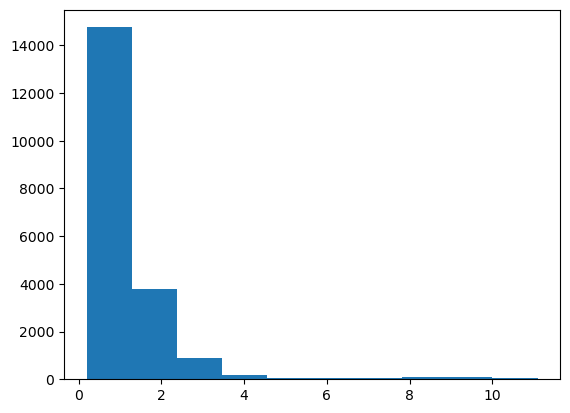

In [9]:
plt.hist(data = fifteen_vehicle_data, x="Consumption_kWh")
plt.show()

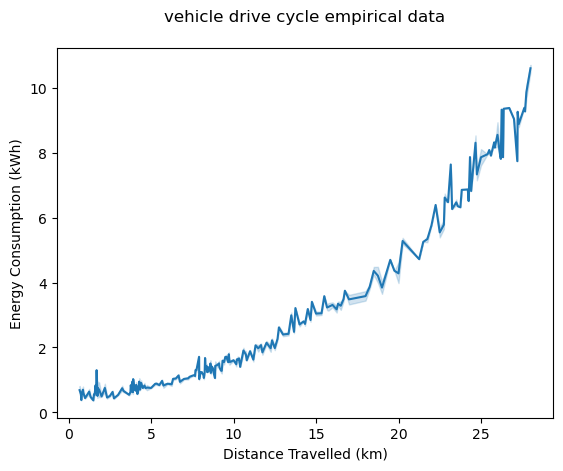

In [10]:
ax = sns.lineplot(data=fifteen_vehicle_data, x="Distance_km", y="Consumption_kWh")
ax.set(xlabel='Distance Travelled (km)', ylabel='Energy Consumption (kWh)')
plt.title(label="vehicle drive cycle empirical data", y=1.05)
#plt.savefig('empirical_output_graph_1_vehicle.png', format='png')
plt.show()

In [11]:
fifteen_vehicle_data = fifteen_vehicle_data.rename(columns={"Distance_km": "Distance_travelled_KM", "Consumption_kWh": "energy_input(kWh)_sum"})

In [12]:
fifteen_vehicle_data["data"] = "emobpy"

# Model outputs

In [13]:
# These are the formulae used from the paper.
# Note - Reference area is a simplification, talk about in paper.

def drag(drag_coefficient, velocity, reference_area, rho=1.225):
    return 0.5 * rho * drag_coefficient * reference_area * (velocity**2)

def engine_force(acceleration, mass, drag_force):
    return (acceleration * mass) + drag_force

#E = F × d
def work_done(force, distance):
    return force * distance

def energy_input(energy_output, efficiency):
    return energy_output / efficiency

In [15]:
# I exported a 35 minute run of the traffic sim with 1 vehicle, the vehicle adhered to speed limits so it only
# managed to do 12 kilometers
model_data = pd.read_csv("Data/ICEV/MC1.txt")

In [16]:
model_data['date-time'] = pd.to_datetime(model_data['date-time'])
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800021 entries, 0 to 1800020
Data columns (total 13 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   AgentID                   int64         
 1   xAxisPos                  float64       
 2   zAxisPos                  float64       
 3   collisions                int64         
 4   topSpeed(mph)             float64       
 5   currentSpeed(mph)         float64       
 6   distanceOfTravel(meters)  float64       
 7   raycastLength             int64         
 8   tractionControl           int64         
 9   VelocityMagnitude(BETA)   float64       
 10  VehicleMass               int64         
 11  Downforce                 float64       
 12  date-time                 datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 178.5 MB


Given that we have mutliple agent IDs in this dataset, we need to process the data for each agent separately.
If we fail to do this, we will end up with distance differences that are really weird.

In [17]:
def prepare_dataset(df):
    # Aggregating to date, averages
    df = df.groupby("date-time").mean()
    
    # Converting meters to kilometers
    df['Distance_travelled_KM'] = df["distanceOfTravel(meters)"] / 1000
    
    # Get difference for meters travelled
    df['distanceOfTravel(meters)_total'] = df['distanceOfTravel(meters)'].diff()
    
    # Get difference for velocity per second
    df['velocity_change'] = df['VelocityMagnitude(BETA)'].diff()
    
    # acceleration is equal the velocity change (s) divided by 1 second.
    df['acceleration'] = df['velocity_change'] / 1
    
    # Remove negative acceleration
    df['acceleration'] = df['acceleration'].apply(lambda x : x if x >= 0 else 0)
    return df

In [18]:
def process_dataset(df):
    # Calculate the force used to overcome drag
    # drag coefficient: 0.33 (Mitsubishi Outlander)
    # reference area 3.078m
    DRAG_COEFFICIENT = 0.341
    REFERENCE_AREA = 2.851
    ENGINE_EFFICIENCY = 0.47

    df['drag_force'] = drag(DRAG_COEFFICIENT, df["VelocityMagnitude(BETA)"], REFERENCE_AREA)
    
    # Calculate the force used to accelerate
    df['acceleration_force'] = df['acceleration'] * df['VehicleMass']
    
    # Calculate the total force exerted by the engine
    df['total_force'] = df['drag_force'] + df['acceleration_force']
    
    # Calculate the work done to overcome drag
    df['drag_work'] = df['distanceOfTravel(meters)_total'] * df['drag_force']

    # Calculatre the work done to accelerate
    df['acceleration_work'] = df['distanceOfTravel(meters)_total'] * df['acceleration_force']

    # Calculate the total work done
    df['total_work'] = df['drag_work'] + df['acceleration_work']
#     df['total_work_2'] = df['distanceOfTravel(meters)_total'] * df['total_force']
    
    df['energy_input'] = df['total_work'] / ENGINE_EFFICIENCY

    df['energy_input_gasl'] = df['total_work'] * 2.9239766081871e-8

    # We get the cumulative energy intake
    df['energy_input(gasl)_sum'] = df['energy_input_gasl'].cumsum()
    
    return df

In [19]:
# Get agent IDs
unique_agent_ids = model_data['AgentID'].unique()

# Prep data for each agent ID
all_data = list()
for agent_id in unique_agent_ids:
    df = model_data.loc[model_data['AgentID']==agent_id, :]
    df = prepare_dataset(df)
    all_data.append(df)

In [20]:
# Process data for each agent ID
processed_data = list()

for agent_data in all_data:
    df = process_dataset(agent_data)
    processed_data.append(df)

In [21]:
# Concatenate all data
processed_data = pd.concat(processed_data)

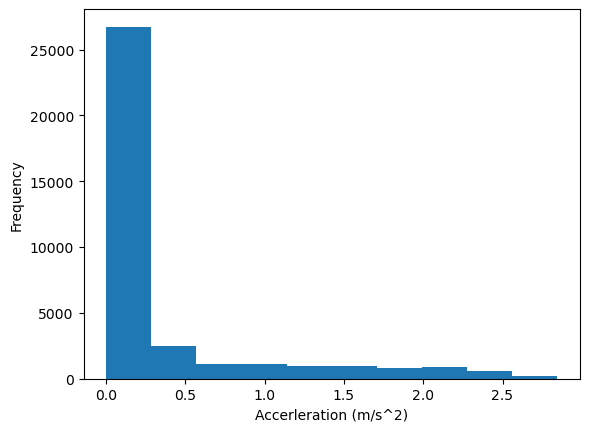

In [22]:
# Check distribution of accelerations
plt.figure()
plt.hist(processed_data['acceleration'])
plt.xlabel('Accerleration (m/s^2)')
plt.ylabel('Frequency')
plt.show()

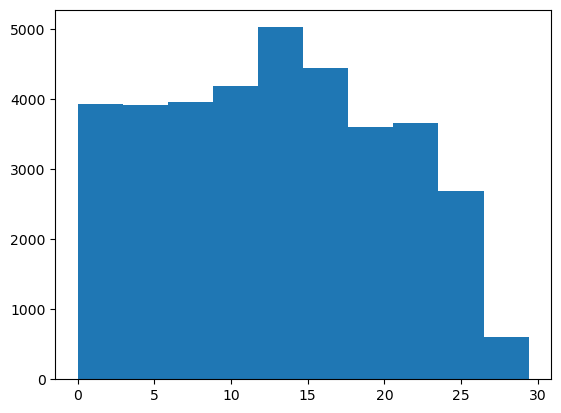

In [23]:
plt.hist(data = processed_data, x="Distance_travelled_KM")
plt.show()

In [50]:
# # Comparing total works
# plt.figure()
# plt.hist(processed_data['total_work'], label='1')
# plt.hist(processed_data['total_work_2'], label='2')
# plt.legend()
# plt.show()

In [24]:
processed_data.head()

,AgentID,xAxisPos,zAxisPos,collisions,topSpeed(mph),currentSpeed(mph),distanceOfTravel(meters),raycastLength,tractionControl,VelocityMagnitude(BETA),...,acceleration,drag_force,acceleration_force,total_force,drag_work,acceleration_work,total_work,energy_input,energy_input_gasl,energy_input(gasl)_sum
date-time,,,,,,,,,,,,,,,,,,,,,
2021-10-20 13:21:39,-51648.0,249.658258,-43.960480,0.0,31.0,2.882586,0.371002,3.0,0.0,1.288595,...,0.000000,0.988759,0.000000,0.988759,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-20 13:21:40,-51648.0,247.324902,-43.962233,0.0,31.0,8.795557,2.712204,3.0,0.0,3.931854,...,2.643259,9.205606,4707.644728,4716.850334,21.552184,11021.547130,11043.099314,23495.955987,0.000323,0.000323
2021-10-20 13:21:41,-51648.0,241.909951,-43.966048,0.0,31.0,15.151454,8.127156,3.0,0.0,6.773113,...,2.841259,27.317085,5060.283063,5087.600148,147.920707,27401.190174,27549.110881,58615.129535,0.000806,0.001128
2021-10-20 13:21:42,-51648.0,233.848333,-43.968304,0.0,31.0,19.760592,16.188944,3.0,0.0,8.900203,...,2.127090,47.169091,3788.346833,3835.515925,380.267231,30540.850375,30921.117606,65789.611928,0.000904,0.002033
2021-10-20 13:21:43,-51648.0,227.071598,-41.707282,0.0,31.0,15.422674,23.980117,3.0,0.0,6.923991,...,0.000000,28.547673,0.000000,28.547673,222.419852,0.000000,222.419852,473.233728,0.000007,0.002039


In [25]:
# Reindex dataframe to avoid plotting issues with duplicate indices
idx = pd.Index(list(range(len(processed_data))))
processed_data.set_index(idx, inplace=True)

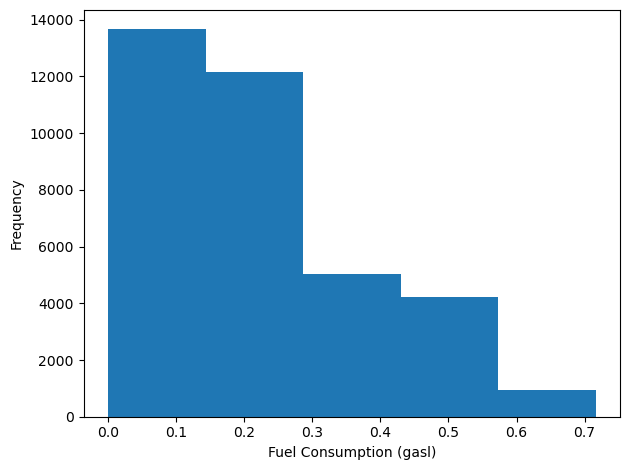

In [27]:
# Check distribution of Energy Consumption.
plt.figure()
plt.hist(processed_data['energy_input(gasl)_sum'], bins=5)
plt.xlabel('Fuel Consumption (gasl)')
plt.ylabel('Frequency')
#plt.axis([0, 10, 0, 300000])
plt.tight_layout()
#plt.savefig('MC7_Energy_Consumption.pdf', format='pdf')
plt.show()

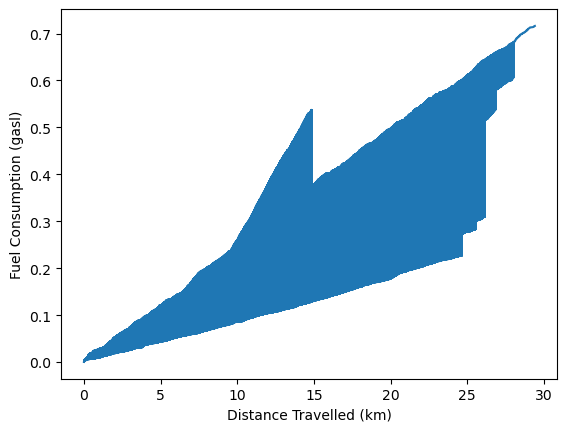

In [28]:
sns.lineplot(data=processed_data, x='Distance_travelled_KM', y='energy_input(gasl)_sum')
plt.xlabel('Distance Travelled (km)')
plt.ylabel('Fuel Consumption (gasl)')
plt.show()

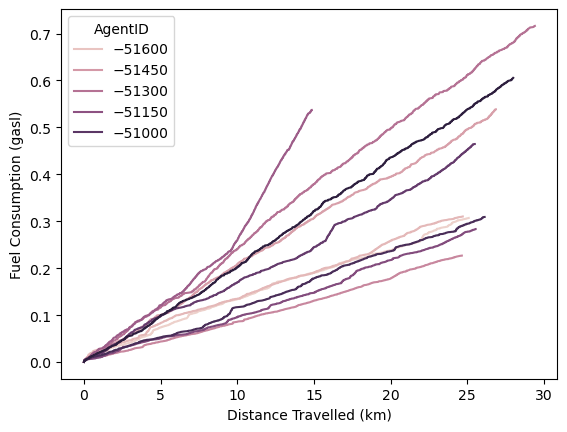

In [29]:
sns.lineplot(data=processed_data, x='Distance_travelled_KM', y='energy_input(gasl)_sum', hue='AgentID')
plt.xlabel('Distance Travelled (km)')
plt.ylabel('Fuel Consumption (gasl)')
plt.show()

In [56]:
processed_data["data"] = "model"

## Merging datasets

In [57]:
merged_df = pd.concat([processed_data, fifteen_vehicle_data])

In [58]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74006 entries, 0 to 525480
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   AgentID                         54015 non-null  float64       
 1   xAxisPos                        54015 non-null  float64       
 2   zAxisPos                        54015 non-null  float64       
 3   collisions                      54015 non-null  float64       
 4   topSpeed(mph)                   54015 non-null  float64       
 5   currentSpeed(mph)               54015 non-null  float64       
 6   distanceOfTravel(meters)        54015 non-null  float64       
 7   raycastLength                   54015 non-null  float64       
 8   tractionControl                 54015 non-null  float64       
 9   VelocityMagnitude(BETA)         54015 non-null  float64       
 10  VehicleMass                     54015 non-null  float64       
 11  D

In [59]:
# Reindexing
idx = pd.Index(list(range(len(merged_df))))
merged_df.set_index(idx, inplace=True)

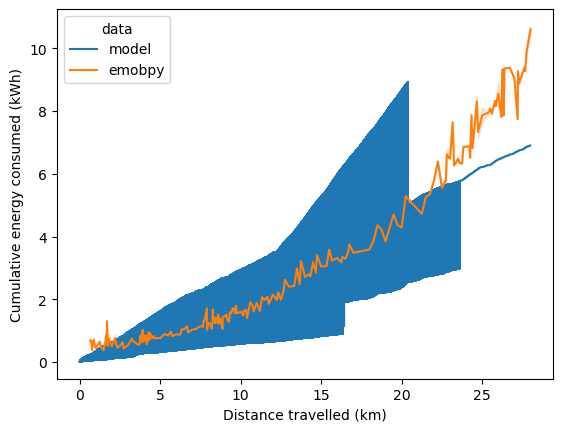

In [60]:
sns.lineplot(data=merged_df,
             x='Distance_travelled_KM', y='energy_input(kWh)_sum',
             hue='data')
plt.xlabel('Distance travelled (km)')
plt.ylabel('Cumulative energy consumed (kWh)')
plt.show()

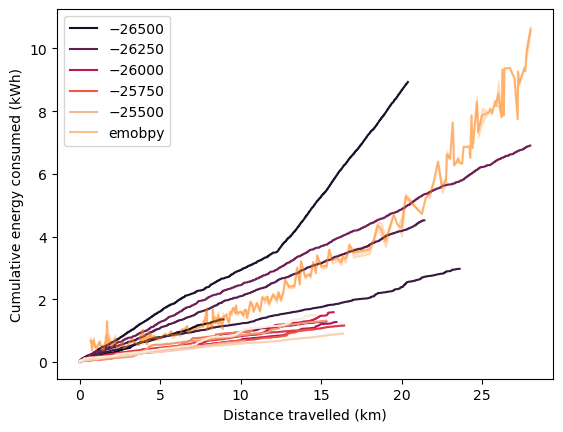

In [61]:
# Overlaying plots from the two datasets
plt.figure()
sns.lineplot(data=processed_data, x='Distance_travelled_KM', y='energy_input(kWh)_sum', hue='AgentID', palette="rocket")
sns.lineplot(data=fifteen_vehicle_data, x='Distance_travelled_KM', y='energy_input(kWh)_sum', label='emobpy', alpha  = 0.5)
plt.xlabel('Distance travelled (km)')
plt.ylabel('Cumulative energy consumed (kWh)')
plt.legend()
#plt.savefig('output_1_15_vehicles.pdf', format='pdf')
plt.show()

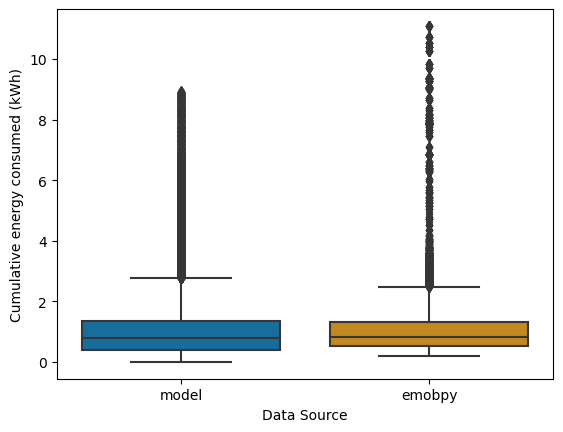

In [62]:
plt.figure()
sns.boxplot(data=merged_df, x='data', y='energy_input(kWh)_sum', palette="colorblind")
#sns.boxplot(data=fifteen_vehicle_data, x='data', y='energy_input(kWh)_sum')
plt.xlabel('Data Source')
plt.ylabel('Cumulative energy consumed (kWh)')
#plt.legend()
#plt.savefig('output_2_15_vehicles.pdf', format='pdf')
plt.show()

# Export BoxPlot for experiments

In [30]:
MC_1 = pd.read_csv("Data/ICEV/MC1.txt")
MC_2 = pd.read_csv("Data/ICEV/MC2.txt")
MC_3 = pd.read_csv("Data/ICEV/MC3.txt")
MC_4 = pd.read_csv("Data/ICEV/MC4.txt")
MC_5 = pd.read_csv("Data/ICEV/MC5.txt")
MC_6 = pd.read_csv("Data/ICEV/MC6.txt")
MC_7 = pd.read_csv("Data/ICEV/MC7.txt")
MC_8 = pd.read_csv("Data/ICEV/MC8.txt")
MC_9 = pd.read_csv("Data/ICEV/MC9.txt")

In [31]:
def pre_process_data(merged_df):
    # Get agent IDs
    unique_agent_ids = merged_df['AgentID'].unique()

    # Prep data for each agent ID
    all_data = list()
    for agent_id in unique_agent_ids:
        df = merged_df.loc[merged_df['AgentID']==agent_id, :]
        df = prepare_dataset(df)
        all_data.append(df)
        
    return all_data

In [32]:
MC_1 = pre_process_data(MC_1)
MC_2 = pre_process_data(MC_2)
MC_3 = pre_process_data(MC_3)
MC_4 = pre_process_data(MC_4)
MC_5 = pre_process_data(MC_5)
MC_6 = pre_process_data(MC_6)
MC_7 = pre_process_data(MC_7)
MC_8 = pre_process_data(MC_8)
MC_9 = pre_process_data(MC_9)

In [33]:
def post_process(data):
    # Process data for each agent ID
    processed_data = list()

    for agent_data in data:
        df = process_dataset(agent_data)
        processed_data.append(df)
        
    return processed_data

In [34]:
MC_1 = post_process(MC_1)
MC_2 = post_process(MC_2)
MC_3 = post_process(MC_3)
MC_4 = post_process(MC_4)
MC_5 = post_process(MC_5)
MC_6 = post_process(MC_6)
MC_7 = post_process(MC_7)
MC_8 = post_process(MC_8)
MC_9 = post_process(MC_9)

In [35]:
processed_data_MC1 = pd.concat(MC_1)
processed_data_MC2 = pd.concat(MC_2)
processed_data_MC3 = pd.concat(MC_3)
processed_data_MC4 = pd.concat(MC_4)
processed_data_MC5 = pd.concat(MC_5)
processed_data_MC6 = pd.concat(MC_6)
processed_data_MC7 = pd.concat(MC_7)
processed_data_MC8 = pd.concat(MC_8)
processed_data_MC9 = pd.concat(MC_9)

In [36]:
def re_index_dataset(processed_data_input):
    # Reindex dataframe to avoid plotting issues with duplicate indices
    idx = pd.Index(list(range(len(processed_data_input))))
    processed_data_input.set_index(idx, inplace=True)
    return processed_data_input

In [37]:
processed_data_MC1 = re_index_dataset(processed_data_MC1)
processed_data_MC2 = re_index_dataset(processed_data_MC2)
processed_data_MC3 = re_index_dataset(processed_data_MC3)
processed_data_MC4 = re_index_dataset(processed_data_MC4)
processed_data_MC5 = re_index_dataset(processed_data_MC5)
processed_data_MC6 = re_index_dataset(processed_data_MC6)
processed_data_MC7 = re_index_dataset(processed_data_MC7)
processed_data_MC8 = re_index_dataset(processed_data_MC8)
processed_data_MC9 = re_index_dataset(processed_data_MC9)

In [38]:
processed_data_MC1["Condition"] = 1
processed_data_MC2["Condition"] = 2
processed_data_MC3["Condition"] = 3
processed_data_MC4["Condition"] = 4
processed_data_MC5["Condition"] = 5
processed_data_MC6["Condition"] = 6
processed_data_MC7["Condition"] = 7
processed_data_MC8["Condition"] = 8
processed_data_MC9["Condition"] = 9

In [39]:
merged_df = pd.concat([processed_data_MC1, processed_data_MC2, processed_data_MC3, 
                       processed_data_MC4, processed_data_MC5, processed_data_MC6, processed_data_MC7, 
                       processed_data_MC8, processed_data_MC9])

In [40]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1813930 entries, 0 to 394499
Data columns (total 26 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   AgentID                         float64
 1   xAxisPos                        float64
 2   zAxisPos                        float64
 3   collisions                      float64
 4   topSpeed(mph)                   float64
 5   currentSpeed(mph)               float64
 6   distanceOfTravel(meters)        float64
 7   raycastLength                   float64
 8   tractionControl                 float64
 9   VelocityMagnitude(BETA)         float64
 10  VehicleMass                     float64
 11  Downforce                       float64
 12  Distance_travelled_KM           float64
 13  distanceOfTravel(meters)_total  float64
 14  velocity_change                 float64
 15  acceleration                    float64
 16  drag_force                      float64
 17  acceleration_force          

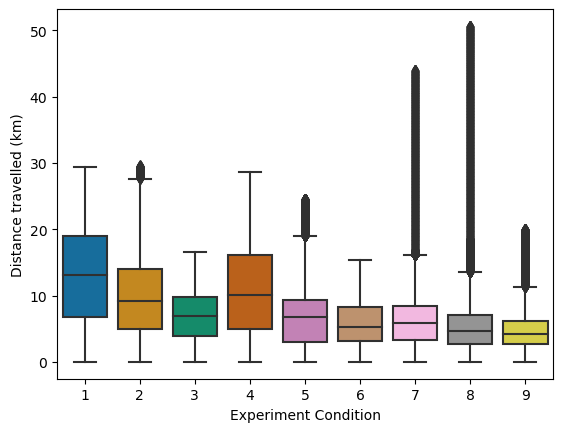

In [43]:
sns.boxplot(x="Condition", y="Distance_travelled_KM", data=merged_df, palette="colorblind")
plt.xlabel('Experiment Condition')
plt.ylabel('Distance travelled (km)')
plt.savefig('Experiment_Condition_Distance_Box_fuel.pdf', format='pdf')
plt.show()

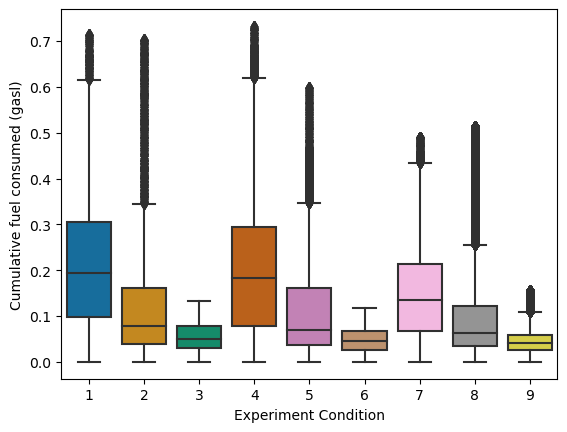

In [44]:
sns.boxplot(x="Condition", y="energy_input(gasl)_sum", data=merged_df, palette="colorblind")
plt.xlabel('Experiment Condition')
plt.ylabel('Cumulative fuel consumed (gasl)')
plt.savefig('Experiment_Condition_Intake_fuel.pdf', format='pdf')
plt.show()